# Install sentencepiece, transformers and pytorch lightning

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import libraries we are going to use

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import BLEUScore
from pprint import pprint
import pickle
import textwrap
import random
import pandas as pd
import matplotlib.pyplot as plt

# Let's play around with T5

![picture](https://drive.google.com/uc?id=1SizdfVBvyWCX61x4FeC89qiyFFvO-FRY)

Source: *Exploring the Limits of Transfer Learning with a Unified
Text-to-Text Transformer* (https://arxiv.org/pdf/1910.10683.pdf)

In [ ]:
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(DEVICE) # we could also use a larger model. E.g.: 't5-base'

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


#### Utility function to display T5's summaries for a given text

In [ ]:
def bold(text):
  return '\033[1m' + text + '\033[0m'
  
def summarize_text(text, tokenizer, model, num_beams=5, num_sentences=5,
                   min_length=30, max_length=100, early_stopping=True):
  preprocess_text = text.strip().replace("\n","")
  t5_prepared_text = "summarize: " + preprocess_text
  print(bold("Original Text:"))
  print(textwrap.fill(text, width=70), end='\n\n')

  tokenized_text = tokenizer.encode(t5_prepared_text, return_tensors="pt").to(DEVICE)

  # summmarize 
  summary_ids = model.generate(tokenized_text,
                              num_beams=num_beams,
                              num_return_sequences=num_sentences,
                              min_length=min_length,
                              max_length=max_length,
                              early_stopping=early_stopping)

  print(bold("Summarized text: \n"))
  for i, beam_output in enumerate(summary_ids):
    output = tokenizer.decode(beam_output, skip_special_tokens=True)
    print(bold(f"Summary {i}:"))
    print(textwrap.fill(output, width=70), end='\n\n')

#### Let's summarize a news from the USA

In [ ]:
text ="""
The US has "passed the peak" on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month.
The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world.
At the daily White House coronavirus briefing on Wednesday, Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors.
"We'll be the comeback kids, all of us," he said. "We want to get our country back."
The Trump administration has previously fixed May 1 as a possible date to reopen the world's largest economy, but the president said some states may be able to return to normalcy earlier than that.
"""

summarize_text(text, tokenizer, model, min_length=100, max_length=150)

Original Text:
 The US has "passed the peak" on new coronavirus cases, President
Donald Trump said and predicted that some states would reopen this
month. The US has over 637,000 confirmed Covid-19 cases and over
30,826 deaths, the highest for any country in the world. At the daily
White House coronavirus briefing on Wednesday, Trump said new
guidelines to reopen the country would be announced on Thursday after
he speaks to governors. "We'll be the comeback kids, all of us," he
said. "We want to get our country back." The Trump administration has
previously fixed May 1 as a possible date to reopen the world's
largest economy, but the president said some states may be able to
return to normalcy earlier than that.

Summarized text: 

Summary 0:
the president predicts some states will reopen this month. the u.s.
has over 637,000 confirmed cases and over 30,826 deaths. "we'll be the
comeback kids, all of us," he says. the president has previously fixed
may 1 as a possible date to reopen th

#### Let's summarize chest X-ray radiology report

In [ ]:
text ="""
New left IJ line ends in the mid SVC.  No pneumothorax or significant pleural
 effusion or mediastinal widening.  Diffuse mild to moderate heterogeneous
 pulmonary abnormality has an interstitial component and the suggestion of
 alveolar opacities or pleural thickening in the upper chest.  The abnormality
 is new since ___, but precise Chronicity is indeterminate and
 differential diagnosis is broad.  This could be all pulmonary edema,
 particular if the patient is hypotensive and in Trendelenburg position.  It
 could be diffuse infection, drug reaction or less likely pulmonary hemorrhage.
 
 Heart is top-normal size, but definitely increased since ___.
 
 ET tube and left internal jugular line are in standard placements and an
 esophageal drainage tube ends in the stomach.
"""

summarize_text(text, tokenizer, model, min_length=30, max_length=100)

Original Text:
 New left IJ line ends in the mid SVC.  No pneumothorax or significant
pleural  effusion or mediastinal widening.  Diffuse mild to moderate
heterogeneous  pulmonary abnormality has an interstitial component and
the suggestion of  alveolar opacities or pleural thickening in the
upper chest.  The abnormality  is new since ___, but precise
Chronicity is indeterminate and  differential diagnosis is broad.
This could be all pulmonary edema,  particular if the patient is
hypotensive and in Trendelenburg position.  It  could be diffuse
infection, drug reaction or less likely pulmonary hemorrhage.    Heart
is top-normal size, but definitely increased since ___.    ET tube and
left internal jugular line are in standard placements and an
esophageal drainage tube ends in the stomach.

Summarized text: 

Summary 0:
the abnormality is new since ___, but precise Chronicity is
indeterminate. this could be all pulmonary edema, particular if the
patient is hypotensive and in Trendelenbur

# Download dataset with pairs of *findings* and *impression* sections from chest X-ray radiology reports.

Our task will be to train a model that generates the *impression* section as a summary/conclusion from the *findings* section.

In [ ]:
!gdown --id 1zIN-6SEIQiliI5Hnm4H9gSnb7mdaih7w -O findings_and_impressions.pkl

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1zIN-6SEIQiliI5Hnm4H9gSnb7mdaih7w
To: /content/findings_and_impressions.pkl
100% 54.9M/54.9M [00:00<00:00, 152MB/s]


In [ ]:
!ls -lh findings_and_impressions.pkl

-rw-r--r-- 1 root root 53M Nov  3 09:35 findings_and_impressions.pkl


In [ ]:
with open('./findings_and_impressions.pkl', 'rb') as f:
    findings_and_impressions = pickle.load(f)

In [ ]:
len(findings_and_impressions)

121440

In [ ]:
pprint(findings_and_impressions[0])

{'findings': 'Heart size is normal. There are mild aortic knob calcifications. '
             'Cardiomediastinal silhouette and hilar contours are otherwise '
             'unremarkable. Lungs are clear. Pleural surfaces are clear '
             'without effusion or pneumothorax.',
 'impression': 'No acute cardiopulmonary abnormality.'}


# Report Summarization Dataset and Training Code

In [ ]:
class ReportSummarizationDataset(Dataset):
  def __init__(self, findings_and_impressions, tokenizer):
    self.findings = [x['findings'] for x in findings_and_impressions]
    self.impressions = [x['impression'] for x in findings_and_impressions]
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.findings)

  def __getitem__(self, idx):
    return {
        'idx': idx,
        'findings': self.findings[idx],
        'impression': self.impressions[idx],
    }
  
  def collate_batch(self, batch):
    encoding = self.tokenizer(
        ['summarize: ' + x['findings'] for x in batch],
        padding="longest",
        max_length=512,
        truncation=True,
        return_tensors="pt",
    )
    target_encoding = self.tokenizer(
        [x['impression'] for x in batch],
        padding="longest",
        max_length=128,
        truncation=True,
        return_tensors="pt",
    )
    labels = target_encoding.input_ids
    labels[labels == self.tokenizer.pad_token_id] = -100
    
    batch_dict = {}
    batch_dict['idx'] = torch.tensor([x['idx'] for x in batch])
    batch_dict['input_ids'] = encoding.input_ids
    batch_dict['attention_mask'] = encoding.attention_mask
    batch_dict['labels'] = labels
    return batch_dict

In [ ]:
class CyclicDataloaderWrapper:
  def __init__(self, loader, n_steps_per_epoch):
    self.n_steps_per_epoch = n_steps_per_epoch
    self.idx = 0
    self.loader = loader
    self.iter_loader = iter(loader)

  def __iter__(self):
    self.iter_loader = iter(self.loader)
    self.idx = 0
    return self

  def __len__(self):
    return self.n_steps_per_epoch

  def __next__(self):
    # if reached number of steps desired, stop
    if self.idx == self.n_steps_per_epoch:
        self.idx = 0
        raise StopIteration
    else:
        self.idx += 1
    # while True
    try:
        return next(self.iter_loader)
    except StopIteration:
        # reinstate iter_loader, then continue
        self.iter_loader = iter(self.loader)
        return next(self.iter_loader)

In [ ]:
class ReportSummarizationModel(pl.LightningModule):

  def __init__(
    self,
    model,
    tokenizer,
  ):
    super().__init__()
    self.model = model
    self.tokenizer = tokenizer
    
    self.train_gt_sentences = []
    self.train_gen_sentences = []
    self.val_gt_sentences = []
    self.val_gen_sentences = []
    self.test_gt_sentences = []
    self.test_gen_sentences = []
    self.test_idxs = []

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=3e-4)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    input_ids = train_batch['input_ids']
    attention_mask = train_batch['attention_mask']
    labels = train_batch['labels']

    output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    logits = output.logits
    loss = output.loss

    # accumulate sentences
    gen_sentences = logits.argmax(-1).detach()
    clean_labels = labels.clone().detach()
    clean_labels[clean_labels == -100] = self.tokenizer.pad_token_id
    for i in range(gen_sentences.size(0)):
      self.train_gen_sentences.append(self.tokenizer.decode(gen_sentences[i], skip_special_tokens=True))
      self.train_gt_sentences.append([self.tokenizer.decode(clean_labels[i], skip_special_tokens=True)])

    # loss
    self.log('train_loss', loss, on_step=False, on_epoch=True, batch_size=input_ids.size(0))
    return loss

  def validation_step(self, val_batch, batch_idx):
    input_ids = val_batch['input_ids']
    attention_mask = val_batch['attention_mask']
    labels = val_batch['labels']

    output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    logits = output.logits
    loss = output.loss

    # accumulate sentences
    gen_sentences = logits.argmax(-1)
    labels[labels == -100] = self.tokenizer.pad_token_id
    for i in range(gen_sentences.size(0)):
      self.val_gen_sentences.append(self.tokenizer.decode(gen_sentences[i], skip_special_tokens=True))
      self.val_gt_sentences.append([self.tokenizer.decode(labels[i], skip_special_tokens=True)])

    # loss
    self.log('val_loss', loss, on_step=False, on_epoch=True, batch_size=input_ids.size(0))

  def test_step(self, test_batch, batch_idx):

    idxs = test_batch['idx']
    input_ids = test_batch['input_ids']
    attention_mask = test_batch['attention_mask']
    labels = test_batch['labels']
    
    gen_sentences = self.model.generate(input_ids=input_ids,
                                        attention_mask=attention_mask,
                                        max_new_tokens=labels.size(1) + 5)
    labels[labels == -100] = self.tokenizer.pad_token_id
    
    # accumulate sentences
    for i in range(gen_sentences.size(0)):
      self.test_gen_sentences.append(self.tokenizer.decode(gen_sentences[i], skip_special_tokens=True))
      self.test_gt_sentences.append([self.tokenizer.decode(labels[i], skip_special_tokens=True)])
      self.test_idxs.append(idxs[i].item())

  def on_train_epoch_start(self):
    self.train_gen_sentences.clear()
    self.train_gt_sentences.clear()

  def on_validation_epoch_start(self):
    self.val_gen_sentences.clear()
    self.val_gt_sentences.clear()
  
  def on_test_epoch_start(self):
    self.test_gen_sentences.clear()
    self.test_gt_sentences.clear()
    self.test_idxs.clear()

  def on_train_epoch_end(self):
    bleu_score = sum(BLEUScore(n_gram=i)(self.train_gen_sentences, self.train_gt_sentences) for i in range(1, 5)) / 4
    self.log('train_bleu', bleu_score)
  
  def on_validation_epoch_end(self):
    bleu_score = sum(BLEUScore(n_gram=i)(self.val_gen_sentences, self.val_gt_sentences) for i in range(1, 5)) / 4
    self.log('val_bleu', bleu_score)

  def on_test_epoch_end(self):
    for i in range(1, 5):
      bleu_score = BLEUScore(n_gram=i)
      self.log(f'test_bleu_{i}', bleu_score(self.test_gen_sentences, self.test_gt_sentences))

### Split dataset into train, validation and test

In [ ]:
main_dataset = ReportSummarizationDataset(findings_and_impressions, tokenizer)

In [ ]:
len(main_dataset)

121440

In [ ]:
val_size = 500
test_size = 500
train_size = len(main_dataset) - val_size - test_size
train_size, val_size, test_size

(120440, 500, 500)

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(main_dataset, [train_size, val_size, test_size])

In [ ]:
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    collate_fn=main_dataset.collate_batch)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    collate_fn=main_dataset.collate_batch)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    collate_fn=main_dataset.collate_batch)

In [ ]:
cyclic_train_dataloader = CyclicDataloaderWrapper(train_dataloader, n_steps_per_epoch=50)

# 1) Evaluate pretrained T5 on Report Summarization (test split)

In [ ]:
report_summarization_model = ReportSummarizationModel(
    model=model,
    tokenizer=tokenizer,
)

In [ ]:
trainer = pl.Trainer(accelerator='gpu', devices=[0])
trainer.test(report_summarization_model, dataloaders=test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1          0.14792488515377045
       test_bleu_2          0.09987861663103104
       test_bleu_3          0.07272189110517502
       test_bleu_4          0.05495523661375046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_bleu_1': 0.14792488515377045,
  'test_bleu_2': 0.09987861663103104,
  'test_bleu_3': 0.07272189110517502,
  'test_bleu_4': 0.05495523661375046}]

In [ ]:
def process_test_predictions():
  bleu_score_1 = BLEUScore(n_gram=1)
  bleu_score_2 = BLEUScore(n_gram=2)
  bleu_score_3 = BLEUScore(n_gram=3)
  bleu_score_4 = BLEUScore(n_gram=4)
  n = len(report_summarization_model.test_gt_sentences)
  output = []
  for i in range(n):
    findings = main_dataset[report_summarization_model.test_idxs[i]]['findings']
    impression_gt = main_dataset[report_summarization_model.test_idxs[i]]['impression']
    # assert impression_gt == report_summarization_model.test_gt_sentences[i][0], (impression_gt, report_summarization_model.test_gt_sentences[i][0])
    impression_gen = report_summarization_model.test_gen_sentences[i]
    output.append({
        'findings': findings,
        'impression_gt': impression_gt,
        'impression_gen': impression_gen,
        'bleu_1': bleu_score_1([impression_gen], [[impression_gt]]).item(),
        'bleu_2': bleu_score_2([impression_gen], [[impression_gt]]).item(),
        'bleu_3': bleu_score_3([impression_gen], [[impression_gt]]).item(),
        'bleu_4': bleu_score_4([impression_gen], [[impression_gt]]).item(),
    })
  output.sort(key=lambda x : x['bleu_1']+x['bleu_2']+x['bleu_3']+x['bleu_4'], reverse=True)
  return output

In [ ]:
test_predictions = process_test_predictions()

# Best 4
for i in range(4):
  print('-' * 80)
  pprint(test_predictions[i])
  print()

# Worst 4
for i in range(1, 5):
  print('-' * 80)
  pprint(test_predictions[-i])
  print()

# Random 4
for i in random.sample(range(20, len(test_predictions) - 20), 4):
  print('-' * 80)
  pprint(test_predictions[i])
  print()

--------------------------------------------------------------------------------
{'bleu_1': 0.66912442445755,
 'bleu_2': 0.6440545916557312,
 'bleu_3': 0.6167428493499756,
 'bleu_4': 0.5867154002189636,
 'findings': 'Endotracheal tube terminates 3.5 cm above the carina. Enteric '
             'tube courses below the diaphragm, into the expected location of '
             'the stomach. A right Port-A-Cath is seen, distal aspect not well '
             'assessed, but likely terminates in the low SVC/cavoatrial '
             'junction. There are low lung volumes. No definite focal '
             'consolidation. No large pleural effusion or pneumothorax. '
             'Cardiac and mediastinal silhouettes are unremarkable given AP, '
             'portable technique.',
 'impression_gen': 'endotracheal tube terminates 3.5 cm above the carina. '
                   'Enteric tube courses below the diaphragm, into the '
                   'expected location of the stomach.',
 'impression_gt': 

In [ ]:
for i in range(1, 5):
  print('-' * 80)
  pprint(test_predictions[-i])
  print()

--------------------------------------------------------------------------------
{'bleu_1': 0.0,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'findings': 'Cardiomediastinal contours are normal. Left lower lobe opacities '
             'likely atelectasis have improved, otherwise The lungs are clear. '
             'There is no pneumothorax or pleural effusion. There are moderate '
             'degenerative changes in the thoracic spine. The right healed rib '
             'fractures are again noted.',
 'impression_gen': 'the right healed rib fractures are again noted.',
 'impression_gt': 'No evidence of pulmonary edema or pneumonia.'}

--------------------------------------------------------------------------------
{'bleu_1': 0.0,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'findings': 'The lungs are clear without focal consolidation. No pleural '
             'effusion or pneumothorax is seen. The cardiac and mediastinal '
             'silhouettes are stable.',
 'impression

In [ ]:
for i in random.sample(range(20, len(test_predictions) - 20), 4):
  print('-' * 80)
  pprint(test_predictions[i])
  print()

--------------------------------------------------------------------------------
{'bleu_1': 0.0,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'findings': 'The lungs are clear. Mild-to-moderate enlargement of the cardiac '
             'silhouette is not significantly changed. The mediastinal '
             'contours are unchanged. There are no pleural effusions. No '
             'pneumothorax is seen.',
 'impression_gen': 'the lungs are clear. there are no pleural effusions.',
 'impression_gt': '1. No acute cardiac or pulmonary process. 2. Unchanged '
                  'mild-to-moderate cardiac enlargement.'}

--------------------------------------------------------------------------------
{'bleu_1': 0.0,
 'bleu_2': 0.0,
 'bleu_3': 0.0,
 'bleu_4': 0.0,
 'findings': 'Cardiomediastinal and hilar contours are stable. There is no '
             'pleural effusion or pneumothorax. Lungs are well expanded and '
             'clear. Pulmonary vasculature is within normal limits. There is 

# 2) Fine-tune pretrained T5 on Report Summarization (train and val splits)

In [ ]:
logger = pl.loggers.CSVLogger("logs", name="report-summarization", version='main')
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="val_bleu",
    mode="max",
    filename="report-summarization-{epoch:02d}-{val_bleu:.4f}",
    save_on_train_epoch_end=True,
)
trainer = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=20,
                     logger=logger, callbacks=[checkpoint_callback])
trainer.fit(report_summarization_model, cyclic_train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:606: UserWarning: Checkpoint directory logs/report-summarization/main/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    To

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
def plot_train_val_curves(logs_path, metric_names, single_plot_figsize=(8, 6)):

    logs = pd.read_csv(logs_path)
    assert len(logs) % 2 == 0
    
    n = len(metric_names)
    ncols = 2 if n > 1 else 1
    nrows = n // ncols + bool(n % ncols)

    figsize = (single_plot_figsize[0] * ncols, single_plot_figsize[1] * nrows)
    plt.figure(figsize=figsize)

    for j in range(n):

        metric_name = metric_names[j]
        train_scores = logs[f'train_{metric_name}']
        train_scores = [train_scores[i] for i in range(1, len(train_scores), 2)]
        val_scores = logs[f'val_{metric_name}']
        val_scores = [val_scores[i] for i in range(0, len(val_scores), 2)]
        assert len(train_scores) == len(val_scores)
        
        epochs = list(range(1, len(train_scores)+1))        
        
        eps = 0.9

        if metric_name == 'loss':
          agg_fn = min
        else:
          agg_fn = max
        
        ax = plt.subplot(nrows, ncols, j+1)
        ax.set_xlim(epochs[0]-eps, epochs[-1]+eps)
        ax.set_title(f'{metric_name} per epoch')
        ax.plot(epochs, train_scores, label=f'{metric_name} (Training)')
        ax.plot(epochs, val_scores, label=f'{metric_name} (Validation)')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric_name)    
        ax.legend()
        best_train_score, best_train_i = agg_fn((a,i) for i,a in enumerate(train_scores))
        ax.hlines(best_train_score, epochs[0], epochs[-1], colors=('green',), linestyles='dashed',
                label=f'best train {metric_name}={best_train_score:.4f}, epoch={best_train_i}')
        best_val_score, best_val_i = agg_fn((a,i) for i,a in enumerate(val_scores))
        ax.hlines(best_val_score, epochs[0], epochs[-1], colors=('red',), linestyles='dashed',
                label=f'best val {metric_name}={best_val_score:.4f}, epoch={best_val_i}')
        ax.legend()
    
    plt.show()

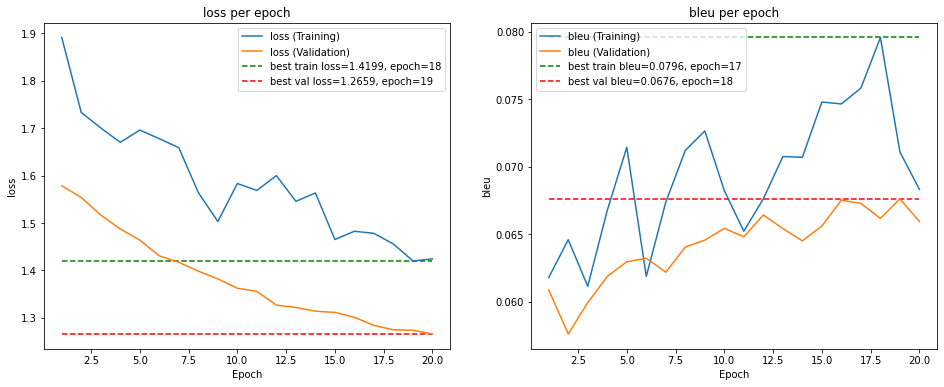

In [ ]:
plot_train_val_curves('logs/report-summarization/main/metrics.csv', ['loss', 'bleu'])

# 3) Evaluate fine-tuned T5 on Report Summarization (test split)

In [ ]:
trainer.test(ckpt_path="best", dataloaders=test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/report-summarization/main/checkpoints/report-summarization-epoch=18-val_bleu=0.0676.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at logs/report-summarization/main/checkpoints/report-summarization-epoch=18-val_bleu=0.0676.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1          0.2720530033111572
       test_bleu_2          0.21862518787384033
       test_bleu_3          0.18104644119739532
       test_bleu_4          0.14866259694099426
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_bleu_1': 0.2720530033111572,
  'test_bleu_2': 0.21862518787384033,
  'test_bleu_3': 0.18104644119739532,
  'test_bleu_4': 0.14866259694099426}]

In [ ]:
test_predictions = process_test_predictions()

# Best 4
for i in range(4):
  print('-' * 80)
  pprint(test_predictions[i])
  print()

# Worst 4
for i in range(1, 5):
  print('-' * 80)
  pprint(test_predictions[-i])
  print()

# Random 4
for i in random.sample(range(20, len(test_predictions) - 20), 4):
  print('-' * 80)
  pprint(test_predictions[i])
  print()

--------------------------------------------------------------------------------
{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'findings': 'PA and lateral chest radiographs demonstrate no focal '
             'consolidation, pleural effusion, or pneumothorax. The '
             'cardiomediastinal silhouette is normal. Cholecystectomy clips '
             'are noted in the right upper quadrant.',
 'impression_gen': 'No acute cardiopulmonary process.',
 'impression_gt': 'No acute cardiopulmonary process.'}

--------------------------------------------------------------------------------
{'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0,
 'findings': 'PA and lateral views of the chest provided. There is no focal '
             'consolidation, effusion, or pneumothorax. The cardiomediastinal '
             'silhouette is normal. Imaged osseous structures are intact. No '
             'free air below the right hemidiaphragm is seen. Focal '
             'even